### Bayesian data analysis
## PyStan demo

Demo for using [Stan](http://mc-stan.org/) with Python interface [PyStan](http://pystan.readthedocs.org).

In [1]:
import numpy as np
import pystan
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# edit default plot settings (colours from colorbrewer2.org)
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))

/u/77/ave/unix/anaconda3/envs/pystanenv/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_98b3dcecef7ac272e69d0b12f6eaf192 NOW.


Inference for Stan model: anon_model_98b3dcecef7ac272e69d0b12f6eaf192.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    0.5  2.8e-3   0.14   0.24    0.4   0.49   0.59   0.76   2429    1.0
lp__   -8.83    0.02   0.72 -10.77  -9.01  -8.55  -8.36  -8.32   2185    1.0

Samples were drawn using NUTS at Sat Feb 25 19:07:31 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


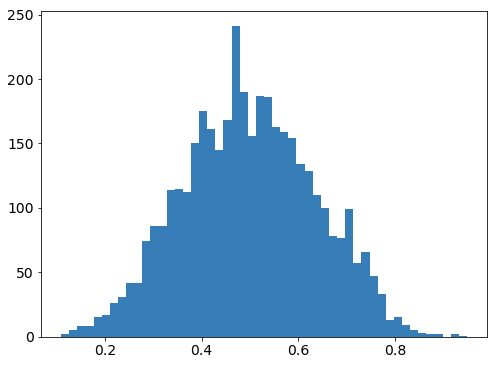

In [3]:
# ====== Bernoulli model =======================================================
bernoulli_code = """
data {
  int<lower=0> N;
  int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  for (n in 1:N)
    y[n] ~ bernoulli(theta);
}
"""
data = dict(N=10, y=[0,1,0,0,1,1,1,0,1,0])
fit = pystan.stan(model_code=bernoulli_code, data=data)
print(fit)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 50);

In [4]:
# ====== Vectorized Bernoulli model ============================================
bernoulli_code = """
data {
  int<lower=0> N;
  int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ bernoulli(theta);
}
"""
data = dict(N=10, y=[1,1,1,0,1,1,1,0,1,1])
fit = pystan.stan(model_code=bernoulli_code, data=data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6e8d72d1ae20097c609d148307eb0a6 NOW.


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_48a128ef4abbd5e7121bd51f9af9f6c5 NOW.


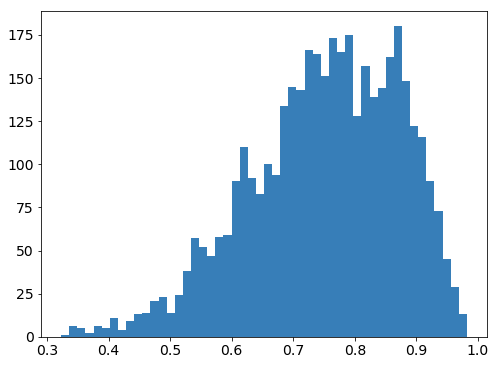

In [5]:
# ====== Binomial model ========================================================
binomial_code = """
data {
  int<lower=0> N;
  int<lower=0> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);
  y ~ binomial(N,theta);
}
"""
data = dict(N=10, y=8)
fit = pystan.stan(model_code=binomial_code, data=data)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 50);

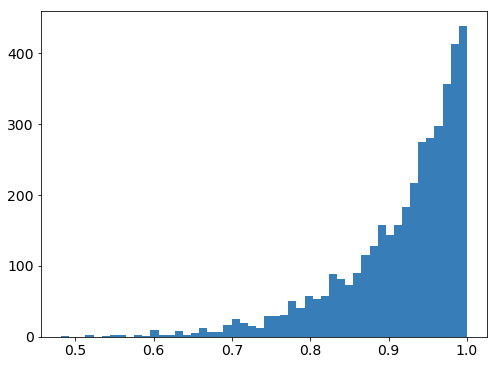

In [6]:
# ====== Re-running Binomial model with new data ===============================
data = dict(N=10, y=10)
fit = pystan.stan(fit=fit, data=data)
samples = fit.extract(permuted=True)
plt.hist(samples['theta'], 50);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4fc7afd496549f436f58ce1b075caad1 NOW.


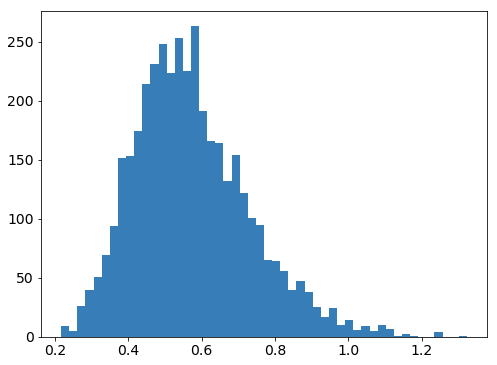

In [7]:
# ====== Comparison of two groups with Binomial ================================
binomial_code = """
data {
  int<lower=0> N1;
  int<lower=0> y1;
  int<lower=0> N2;
  int<lower=0> y2;
}
parameters {
  real<lower=0,upper=1> theta1;
  real<lower=0,upper=1> theta2;
}
model {
  theta1 ~ beta(1,1);
  theta2 ~ beta(1,1);
  y1 ~ binomial(N1,theta1);
  y2 ~ binomial(N2,theta2);
}
generated quantities {
  real oddsratio;
  oddsratio = (theta2/(1-theta2))/(theta1/(1-theta1));
}
"""
data = dict(N1=674, y1=39, N2=680, y2=22)
fit = pystan.stan(model_code=binomial_code, data=data)
samples = fit.extract(permuted=True)
plt.hist(samples['oddsratio'], 50);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2fbd3bf55dc623398b31c11c217abcfb NOW.


Pr(beta > 0) = 0.99025


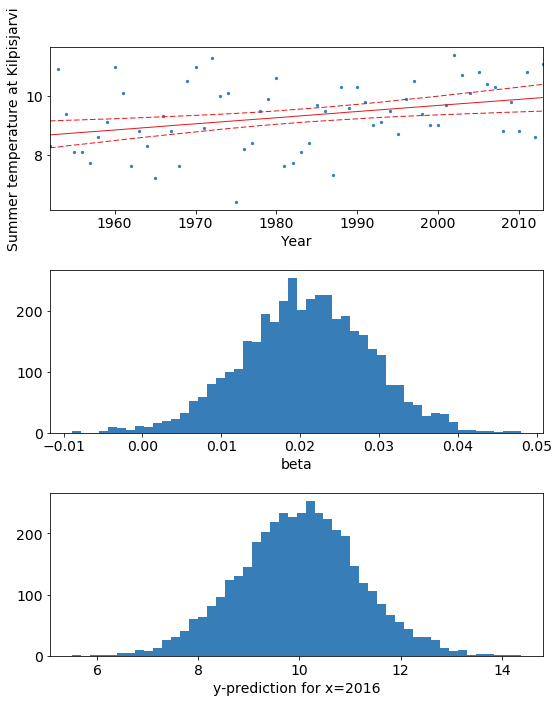

In [13]:
# ====== Gaussian linear model =================================================
linear_code = """
data {
    int<lower=0> N; // number of data points 
    vector[N] x; // 
    vector[N] y; // 
    real xpred; // input location for prediction
}
parameters {
    real alpha; 
    real beta; 
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    vector[N] log_lik;
    ypred = normal_rng(alpha + beta*xpred, sigma);
    for (n in 1:N)
        log_lik[n] = normal_log(y[n], alpha + beta*x[n], sigma);}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
x = d[:,0]
y = d[:,4]
N = len(x)
xpred = 2016
data = dict(N=N, x=x, y=y, xpred=xpred)
# Compile and fit the model
fit = pystan.stan(model_code=linear_code, data=data)

# Module psis.py in github repository https://github.com/avehtari/PSIS provide
# function psisloo() for calculating Pareto smoothed importance sampling (PSIS)
# leave-one-out cross-validation.
# loo, loos, ks = psisloo(samples['log_lik'])

# Plot
samples = fit.extract(permuted=True)
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(x,
    np.percentile(samples['mu'], 50, axis=0),
    color='#e41a1c',
    linewidth=1
)
plt.plot(
    x,
    np.asarray(np.percentile(samples['mu'], [5, 95], axis=0)).T,
    color='#e41a1c',
    linestyle='--',
    linewidth=1,
)
plt.scatter(x, y, 5, color='#377eb8')
plt.xlabel('Year')
plt.ylabel('Summer temperature at Kilpisjarvi')
plt.xlim((1952,2013))
plt.subplot(3,1,2)
plt.hist(samples['beta'], 50)
plt.xlabel('beta')
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta']>0)))
plt.subplot(3,1,3)
plt.hist(samples['ypred'], 50)
plt.xlabel('y-prediction for x={}'.format(xpred))
plt.tight_layout();

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e41448a90b77fdbc0f85cbae0a6ec3b NOW.


Pr(beta > 0) = 0.99725


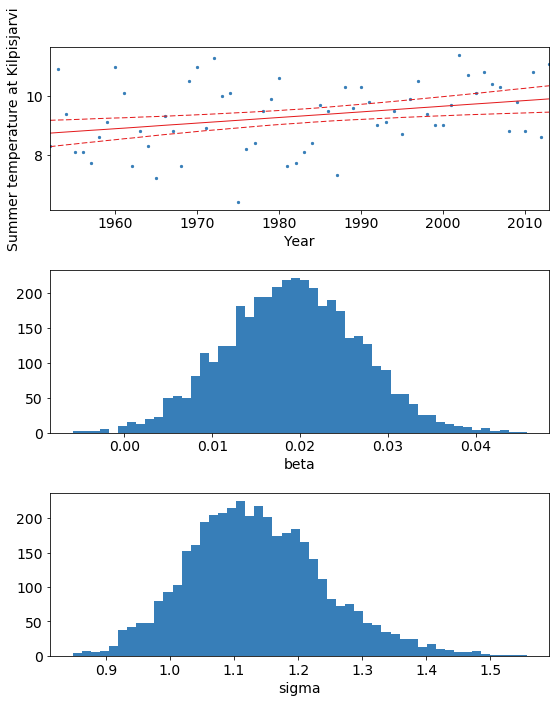

In [14]:
# ====== Gaussian linear model with adjustable priors ==========================
linear_code = """
data {
    int<lower=0> N; // number of data points 
    vector[N] x; // 
    vector[N] y; // 
    real pmualpha; // prior mean for alpha
    real psalpha;  // prior std for alpha
    real pmubeta;  // prior mean for beta
    real psbeta;   // prior std for beta
}
parameters {
    real alpha; 
    real beta; 
    real<lower=0> sigma;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    alpha ~ normal(pmualpha,psalpha);
    beta ~ normal(pmubeta,psbeta);
    y ~ normal(mu, sigma);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
x = d[:,0]
y = d[:,4]
N = len(x)
data = dict(
    N = N,
    x = x,
    y = y,
    pmualpha = y.mean(),    # Centered
    psalpha  = 100,        # weakly informative prior
    pmubeta  = 0,           # a priori increase and decrese as likely
    psbeta   = (.1--.1)/6.0 # avg temp probably does not increase more than 1
                            # degree per 10 years
)
# Compile and fit the model
fit = pystan.stan(model_code=linear_code, data=data)

# Plot
samples = fit.extract(permuted=True)
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(x,
    np.percentile(samples['mu'], 50, axis=0),
    color='#e41a1c',
    linewidth=1
)
plt.plot(
    x,
    np.asarray(np.percentile(samples['mu'], [5, 95], axis=0)).T,
    color='#e41a1c',
    linestyle='--',
    linewidth=1,
)
plt.scatter(x, y, 5, color='#377eb8')
plt.xlabel('Year')
plt.ylabel('Summer temperature at Kilpisjarvi')
plt.xlim((1952,2013))
plt.subplot(3,1,2)
plt.hist(samples['beta'], 50)
plt.xlabel('beta')
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta']>0)))
plt.subplot(3,1,3)
plt.hist(samples['sigma'], 50)
plt.xlabel('sigma')
plt.tight_layout();

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5cfb98573dd549090da6595c4dfaa77 NOW.


Pr(beta > 0) = 0.995


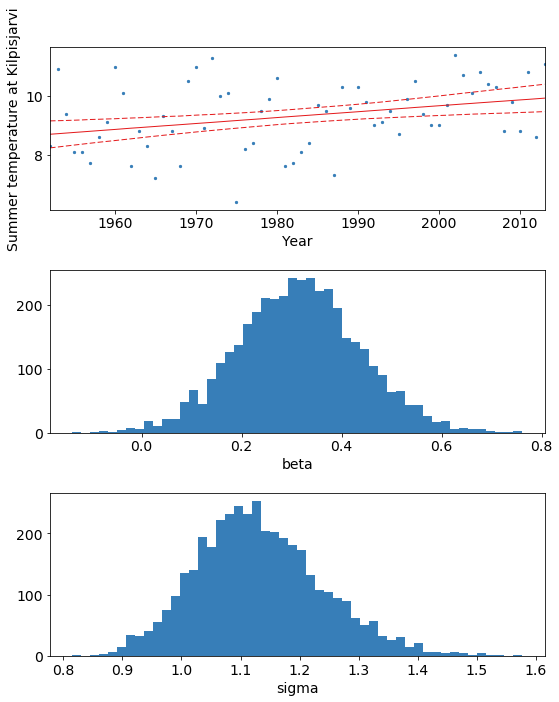

In [31]:
# ====== Gaussian linear model with standardized data ==========================
linear_code = """
data {
    int<lower=0> N; // number of data points 
    vector[N] x; // 
    vector[N] y; // 
}
transformed data {
  vector[N] x_std;
  vector[N] y_std;
  x_std = (x - mean(x)) / sd(x);
  y_std = (y - mean(y)) / sd(y);
}
parameters {
    real alpha; 
    real beta; 
    real<lower=0> sigma_std;
}
transformed parameters {
    vector[N] mu_std;
    mu_std = alpha + beta*x_std;
}
model {
  alpha ~ normal(0,1);
  beta ~ normal(0,1);
  y_std ~ normal(mu_std, sigma_std);
}
generated quantities {
    vector[N] mu;
    real<lower=0> sigma;
    mu = mean(y) + mu_std*sd(y);
    sigma = sigma_std*sd(y);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
x = d[:,0]
y = d[:,4]
N = len(x)
data = dict(N = N, x = x, y = y)
# Compile and fit the model
fit = pystan.stan(model_code=linear_code, data=data)

# Plot
samples = fit.extract(permuted=True)
plt.figure(figsize=(8,10))
plt.subplot(3,1,1)
plt.plot(x,
    np.percentile(samples['mu'], 50, axis=0),
    color='#e41a1c',
    linewidth=1
)
plt.plot(
    x,
    np.asarray(np.percentile(samples['mu'], [5, 95], axis=0)).T,
    color='#e41a1c',
    linestyle='--',
    linewidth=1,
)
plt.scatter(x, y, 5, color='#377eb8')
plt.xlabel('Year')
plt.ylabel('Summer temperature at Kilpisjarvi')
plt.xlim((1952,2013))
plt.subplot(3,1,2)
plt.hist(samples['beta'], 50)
plt.xlabel('beta')
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta']>0)))
plt.subplot(3,1,3)
plt.hist(samples['sigma'], 50)
plt.xlabel('sigma')
plt.tight_layout();

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e498ac9e21883fdbaebcc9fea58c6d5a NOW.


Pr(beta > 0) = 0.99625


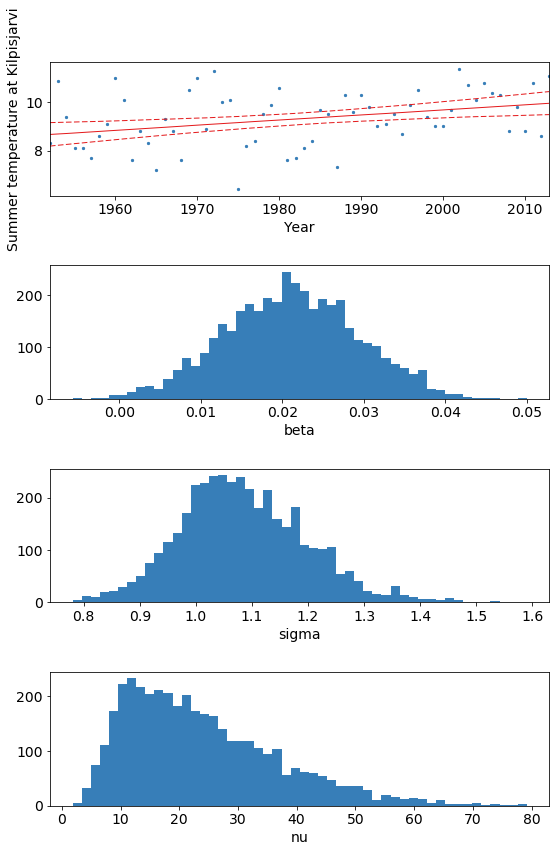

In [16]:
# ====== Gaussian linear student-t model =======================================
linear_code = """
data {
    int<lower=0> N; // number of data points 
    vector[N] x; // 
    vector[N] y; // 
}
parameters {
    real alpha; 
    real beta; 
    real<lower=0> sigma;
    real<lower=1,upper=80> nu;
}
transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}
model {
    nu ~ gamma(2,0.1); // Juarez and Steel (2010)
    y ~ student_t(nu, mu, sigma);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
x = d[:,0]
y = d[:,4]
N = len(x)
data = dict(N = N, x = x, y = y)
# Compile and fit the model
fit = pystan.stan(model_code=linear_code, data=data)

# Plot
samples = fit.extract(permuted=True)
plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
plt.plot(x,
    np.percentile(samples['mu'], 50, axis=0),
    color='#e41a1c',
    linewidth=1
)
plt.plot(
    x,
    np.asarray(np.percentile(samples['mu'], [5, 95], axis=0)).T,
    color='#e41a1c',
    linestyle='--',
    linewidth=1,
)
plt.scatter(x, y, 5, color='#377eb8')
plt.xlabel('Year')
plt.ylabel('Summer temperature at Kilpisjarvi')
plt.xlim((1952,2013))
plt.subplot(4,1,2)
plt.hist(samples['beta'], 50)
plt.xlabel('beta')
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta']>0)))
plt.subplot(4,1,3)
plt.hist(samples['sigma'], 50)
plt.xlabel('sigma')
plt.subplot(4,1,4)
plt.hist(samples['nu'], 50)
plt.xlabel('nu')
plt.tight_layout();

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f31b4f88a2146801e9b2353c43cea3d NOW.


Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb4a0b7320>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7feb4a0b7240>}

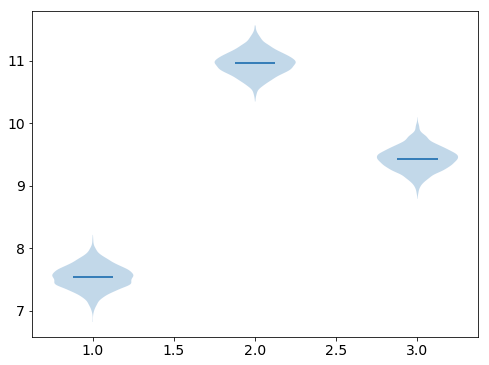

In [27]:
# ==== Comparison of k groups with equal variances (ANOVA) =====================
group_code = """
data {
    int<lower=0> N; // number of data points 
    int<lower=0> K; // number of groups 
    int<lower=1,upper=K> x[N]; // group indicator 
    vector[N] y; // 
}
parameters {
    vector[K] mu;        // group means
    real<lower=0> sigma; // common stds
}
model {
    for (n in 1:N)
      y[n] ~ normal(mu[x[n]], sigma);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
# Is there difference between different summer months?
x = np.tile(np.arange(1,4), d.shape[0]) # summer months are numbered from 1 to 3
y = d[:,1:4].ravel()
N = len(x)
data = dict(
    N = N,
    K = 3,  # 3 groups
    x = x,  # group indicators
    y = y   # observations
)
# Compile and fit the model
fit = pystan.stan(model_code=group_code, data=data)

# Analyse results
mu = fit.extract(permuted=True)['mu']
# Matrix of probabilities that one mu is larger than other
ps = np.zeros((3,3))
for k1 in range(3):
    for k2 in range(k1+1,3):
        ps[k1,k2] = np.mean(mu[:,k1]>mu[:,k2])
        ps[k2,k1] = 1 - ps[k1,k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)
# Plot
plt.violinplot(mu,showmeans=True,showextrema=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c213104ae499435c2d6dec46a001c06c NOW.


Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb49856978>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7feb49856da0>}

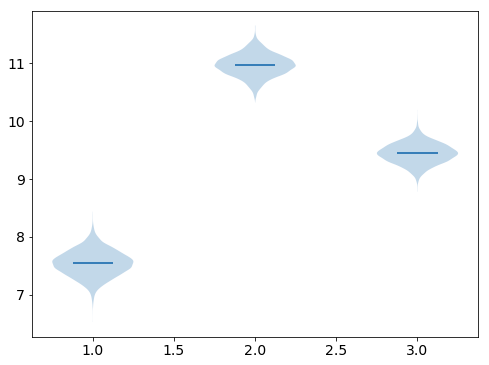

In [28]:
# ==== Comparison of k groups with unequal variances ===========================
group_code = """
data {
    int<lower=0> N; // number of data points 
    int<lower=0> K; // number of groups 
    int<lower=1,upper=K> x[N]; // group indicator 
    vector[N] y; // 
}
parameters {
    vector[K] mu;    // group means 
    vector<lower=0>[K] sigma; // group stds 
}
model {
    for (n in 1:N)
      y[n] ~ normal(mu[x[n]], sigma[x[n]]);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
# Is there difference between different summer months?
x = np.tile(np.arange(1,4), d.shape[0]) # summer months are numbered from 1 to 3
y = d[:,1:4].ravel()
N = len(x)
data = dict(
    N = N,
    K = 3,  # 3 groups
    x = x,  # group indicators
    y = y   # observations
)
# Compile and fit the model
fit = pystan.stan(model_code=group_code, data=data)

# Analyse results
mu = fit.extract(permuted=True)['mu']
# Matrix of probabilities that one mu is larger than other
ps = np.zeros((3,3))
for k1 in range(3):
    for k2 in range(k1+1,3):
        ps[k1,k2] = np.mean(mu[:,k1]>mu[:,k2])
        ps[k2,k1] = 1 - ps[k1,k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)
# Plot
plt.violinplot(mu,showmeans=True,showextrema=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce553fe2ef7d33ac6c5092c27e5027ed NOW.


std(mu0): 2.0029411960320096
Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb4a665a20>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7feb4a665f98>}

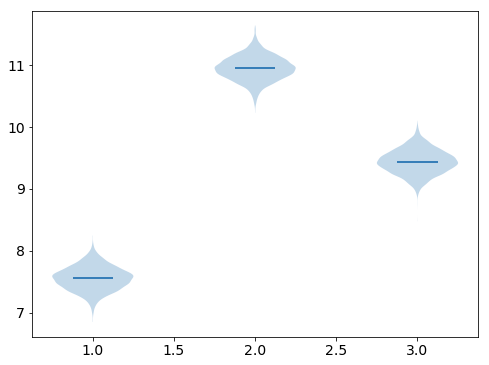

In [29]:
# ==== Hierarchical prior for means in comparison of k groups ==================
# results do not differ much from the previous, because there is only
# few groups and quite much data per group, but this works as an example anyway
hier_code = """
data {
    int<lower=0> N; // number of data points 
    int<lower=0> K; // number of groups 
    int<lower=1,upper=K> x[N]; // group indicator 
    vector[N] y; // 
}
parameters {
    real mu0;             // prior mean 
    real<lower=0> sigma0; // prior std 
    vector[K] mu;         // group means 
    real<lower=0> sigma;  // common std 
}
model {
    mu0 ~ normal(10,10);      // weakly informative prior 
    sigma0 ~ cauchy(0,4);     // weakly informative prior 
    mu ~ normal(mu0, sigma0); // population prior with unknown parameters
    sigma ~ cauchy(0,4);      // weakly informative prior
    for (n in 1:N)
      y[n] ~ normal(mu[x[n]], sigma);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
# Is there difference between different summer months?
x = np.tile(np.arange(1,4), d.shape[0]) # summer months are numbered from 1 to 3
y = d[:,1:4].ravel()
N = len(x)
data = dict(
    N = N,
    K = 3,  # 3 groups
    x = x,  # group indicators
    y = y   # observations
)
# Compile and fit the model
fit = pystan.stan(model_code=hier_code, data=data)

# Analyse results
samples = fit.extract(permuted=True)
print("std(mu0): {}".format(np.std(samples['mu0'])))
mu = samples['mu']
# Matrix of probabilities that one mu is larger than other
ps = np.zeros((3,3))
for k1 in range(3):
    for k2 in range(k1+1,3):
        ps[k1,k2] = np.mean(mu[:,k1]>mu[:,k2])
        ps[k2,k1] = 1 - ps[k1,k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)
# Plot
plt.violinplot(mu,showmeans=True,showextrema=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c5cd172774c9a0131d86269f91c65e62 NOW.


std(mu0): 2.31779304483086
Matrix of probabilities that one mu is larger than other:
[[ 0.  0.  0.]
 [ 1.  0.  1.]
 [ 1.  0.  0.]]


{'bodies': [<matplotlib.collections.PolyCollection at 0x7feb49d40160>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7feb49d40e80>}

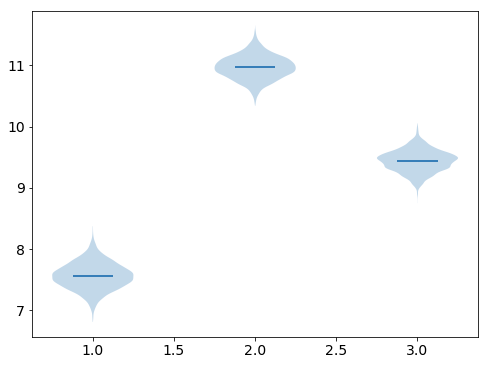

In [30]:
# ==== Hierarchical prior for means and variances in comparison of k groups ====
# results do not differ much from the previous, because there is only
# few groups and quite much data per group, but this works as an example anyway
hier_code = """
data {
    int<lower=0> N; // number of data points 
    int<lower=0> K; // number of groups 
    int<lower=1,upper=K> x[N]; // group indicator 
    vector[N] y; // 
}
parameters {
    real mu0;                 // prior mean 
    real<lower=0> musigma0;   // prior std 
    vector[K] mu;             // group means
    real lsigma0;
    real<lower=0> lsigma0s;
    vector<lower=0>[K] sigma; // group stds 
}
model {
    mu0 ~ normal(10,10);         // weakly informative prior 
    musigma0 ~ cauchy(0,10);     // weakly informative prior 
    mu ~ normal(mu0, musigma0);  // population prior with unknown parameters
    lsigma0 ~ normal(0,1);       // weakly informative prior
    lsigma0s ~ normal(0,1);      // weakly informative prior
    sigma ~ lognormal(lsigma0, lsigma0s); // popul prior with unknown params
    for (n in 1:N)
      y[n] ~ normal(mu[x[n]], sigma[x[n]]);
}
"""
# Data for Stan
data_path = '../utilities_and_data/kilpisjarvi-summer-temp.csv'
d = np.loadtxt(data_path, dtype=np.double, delimiter=';', skiprows=1)
# Is there difference between different summer months?
x = np.tile(np.arange(1,4), d.shape[0]) # summer months are numbered from 1 to 3
y = d[:,1:4].ravel()
N = len(x)
data = dict(
    N = N,
    K = 3,  # 3 groups
    x = x,  # group indicators
    y = y   # observations
)
# Compile and fit the model
fit = pystan.stan(model_code=hier_code, data=data)

# Analyse results
samples = fit.extract(permuted=True)
print("std(mu0): {}".format(np.std(samples['mu0'])))
mu = samples['mu']
# Matrix of probabilities that one mu is larger than other
ps = np.zeros((3,3))
for k1 in range(3):
    for k2 in range(k1+1,3):
        ps[k1,k2] = np.mean(mu[:,k1]>mu[:,k2])
        ps[k2,k1] = 1 - ps[k1,k2]
print("Matrix of probabilities that one mu is larger than other:")
print(ps)
# Plot
plt.violinplot(mu,showmeans=True,showextrema=False)